In [ ]:
import sys
import copy
from einops import rearrange
import numpy as np
import numpy.random as rn
from scipy.special import softmax
from numpy import linalg
from scipy.optimize import linprog  
sys.path.append('../..')
from examples.safe_PCE import *
random.seed(10)
np.random.seed(10)

In [ ]:
def Sample_CMDP(env, policy, counts_sa, counts_sa2s):
    state = rn.choice(env.n, p = env.nu0)
    for _ in range(600):
        action = np.random.choice(env.m, p = policy[state, :])
        next_state= np.random.choice(env.n, p = env.P[state, action, :]) 
        counts_sa[state, action] += 1
        counts_sa2s[state, action, next_state] += 1
        state = next_state
        # reach the absorbing state, break
        if next_state == 45:
            for action in range(env.m):
                counts_sa[next_state, action] += 1
                counts_sa2s[next_state, action, next_state] += 1
            break
    return counts_sa, counts_sa2s

def Etimate_P_Confidence(env, counts_sa, counts_sa2s):
    # Estimate transition probabilities and confidence intervals
    P_est = np.zeros((env.n, env.m, env.n))
    confidence = np.zeros((env.n, env.m, env.n))
    # L = np.log(2 * env.n * env.m * 400000 / (1 - env.gamma)) --- Not working, it is too large ---
    L = 3e-02 # 1e-03 is not working well as it is unsafe sometimes, 1e-02 is better in safety but less good for optimality, finaly tuned with 3e-02 
    for s in range(env.n):
        for a in range(env.m):
            for s_next in range(env.n):
                if counts_sa[s, a] > 0:
                    P_est[s, a, s_next] = counts_sa2s[s, a, s_next] / counts_sa[s, a]
                    var = P_est[s, a, s_next] * (1 - P_est[s, a, s_next])
                    confidence[s, a, s_next] = np.sqrt(4 * L * var / counts_sa[s, a]) + 14 * L / (3 * counts_sa[s, a]) 
                else:
                    P_est[s, a, s_next] = 1 / env.n
                    confidence[s, a, s_next] = 14 * L / 3

    return P_est, np.sum(confidence, axis=2) 

def LP_solve(env, P_est, confidence):
    r = env.r.copy()
    r = rearrange(r + confidence/(0.1 * (1 - env.gamma) ** 2), 's a -> (s a)')
    Psi = env.Psi.copy()
    Psi[:, :, 0] += confidence/(1 - env.gamma)
    Psi = rearrange(Psi, 's a k-> (s a) k')
    
    # Construct the flow conservation constraint matrix
    # For each state s: sum_a d(s,a) - gamma * sum_{s',a'} P(s|s',a') * d(s',a') = (1-gamma) * nu0(s)
    A_eq = np.zeros((env.n, env.n * env.m))
    for s in range(env.n):
        # Outflow: sum_a d(s,a)
        A_eq[s, s * env.m:(s + 1) * env.m] = 1
        # Inflow: -gamma * sum_{s',a'} P(s|s',a') * d(s',a')
        for sp in range(env.n):
            for ap in range(env.m):
                idx = sp * env.m + ap
                A_eq[s, idx] -= env.gamma * P_est[sp, ap, s]
    
    b_eq = (1 - env.gamma) * env.nu0
    
    sol = linprog(-r / (1 - env.gamma), A_eq=A_eq, b_eq=b_eq,
                  A_ub=Psi.T / (1-env.gamma), b_ub=env.b, bounds=(0, None))
    if sol.x is None or not sol.success:
        return None, sol
    # Manually convert vector to tensor format (s, a) shape
    occ_tensor = rearrange(sol.x, '(s a) -> s a', a=env.m)
    return env.occ2policy(occ_tensor), sol

def DOPE(env, pi_s, max_iters = 30000):
    counts_sa = np.zeros((env.n, env.m))
    counts_sa2s = np.zeros((env.n, env.m, env.n))
    _, u_optimal, _ = LP(env)
    reward_regret = np.zeros(max_iters)
    cost_hist = np.zeros(max_iters)
    r_s, c_s = value_function_r_c(env, pi_s)
    for it in range(max_iters):
        # safe exploration phase to collect data
        if it < 11000: #too small number will lead to infeasible LP later and back to safe policy
            counts_sa, counts_sa2s = Sample_CMDP(env, pi_s, counts_sa, counts_sa2s)
            reward_regret[it] = (u_optimal - r_s) * (it + 1)
            cost_hist[it] = np.asarray(c_s).ravel()[0]
        else:
            # estimate transition
            P_est, confidence = Etimate_P_Confidence(env, counts_sa, counts_sa2s)
            # update policy using estimated transition
            policy, sol = LP_solve(env, P_est, confidence)
            if sol.x is None or not sol.success:
                print(f"At iteration {it}, LP failed, using safe policy")
                policy = pi_s  # fallback to safe policy if LP fails
                print(value_function_r_c(env, policy))
            counts_sa, counts_sa2s = Sample_CMDP(env, policy, counts_sa, counts_sa2s)
            r_s, c_s = value_function_r_c(env, policy)
            reward_regret[it] = (u_optimal - r_s) + reward_regret[it - 1]
            cost_hist[it] = np.asarray(c_s).ravel()[0]
            if cost_hist[it] > env.b:
                print(f"Iteration {it}, constraint violated: cost = {cost_hist[it]}")
    return reward_regret, cost_hist

At iteration 11000, LP failed, using safe policy
(47.59763940934204, array([1.13145921]))
At iteration 11001, LP failed, using safe policy
(47.59763940934204, array([1.13145921]))
At iteration 11002, LP failed, using safe policy
(47.59763940934204, array([1.13145921]))
At iteration 11003, LP failed, using safe policy
(47.59763940934204, array([1.13145921]))
At iteration 11004, LP failed, using safe policy
(47.59763940934204, array([1.13145921]))
At iteration 11005, LP failed, using safe policy
(47.59763940934204, array([1.13145921]))
At iteration 11006, LP failed, using safe policy
(47.59763940934204, array([1.13145921]))
At iteration 11007, LP failed, using safe policy
(47.59763940934204, array([1.13145921]))
At iteration 11008, LP failed, using safe policy
(47.59763940934204, array([1.13145921]))
At iteration 11009, LP failed, using safe policy
(47.59763940934204, array([1.13145921]))
At iteration 11010, LP failed, using safe policy
(47.59763940934204, array([1.13145921]))
At iterati

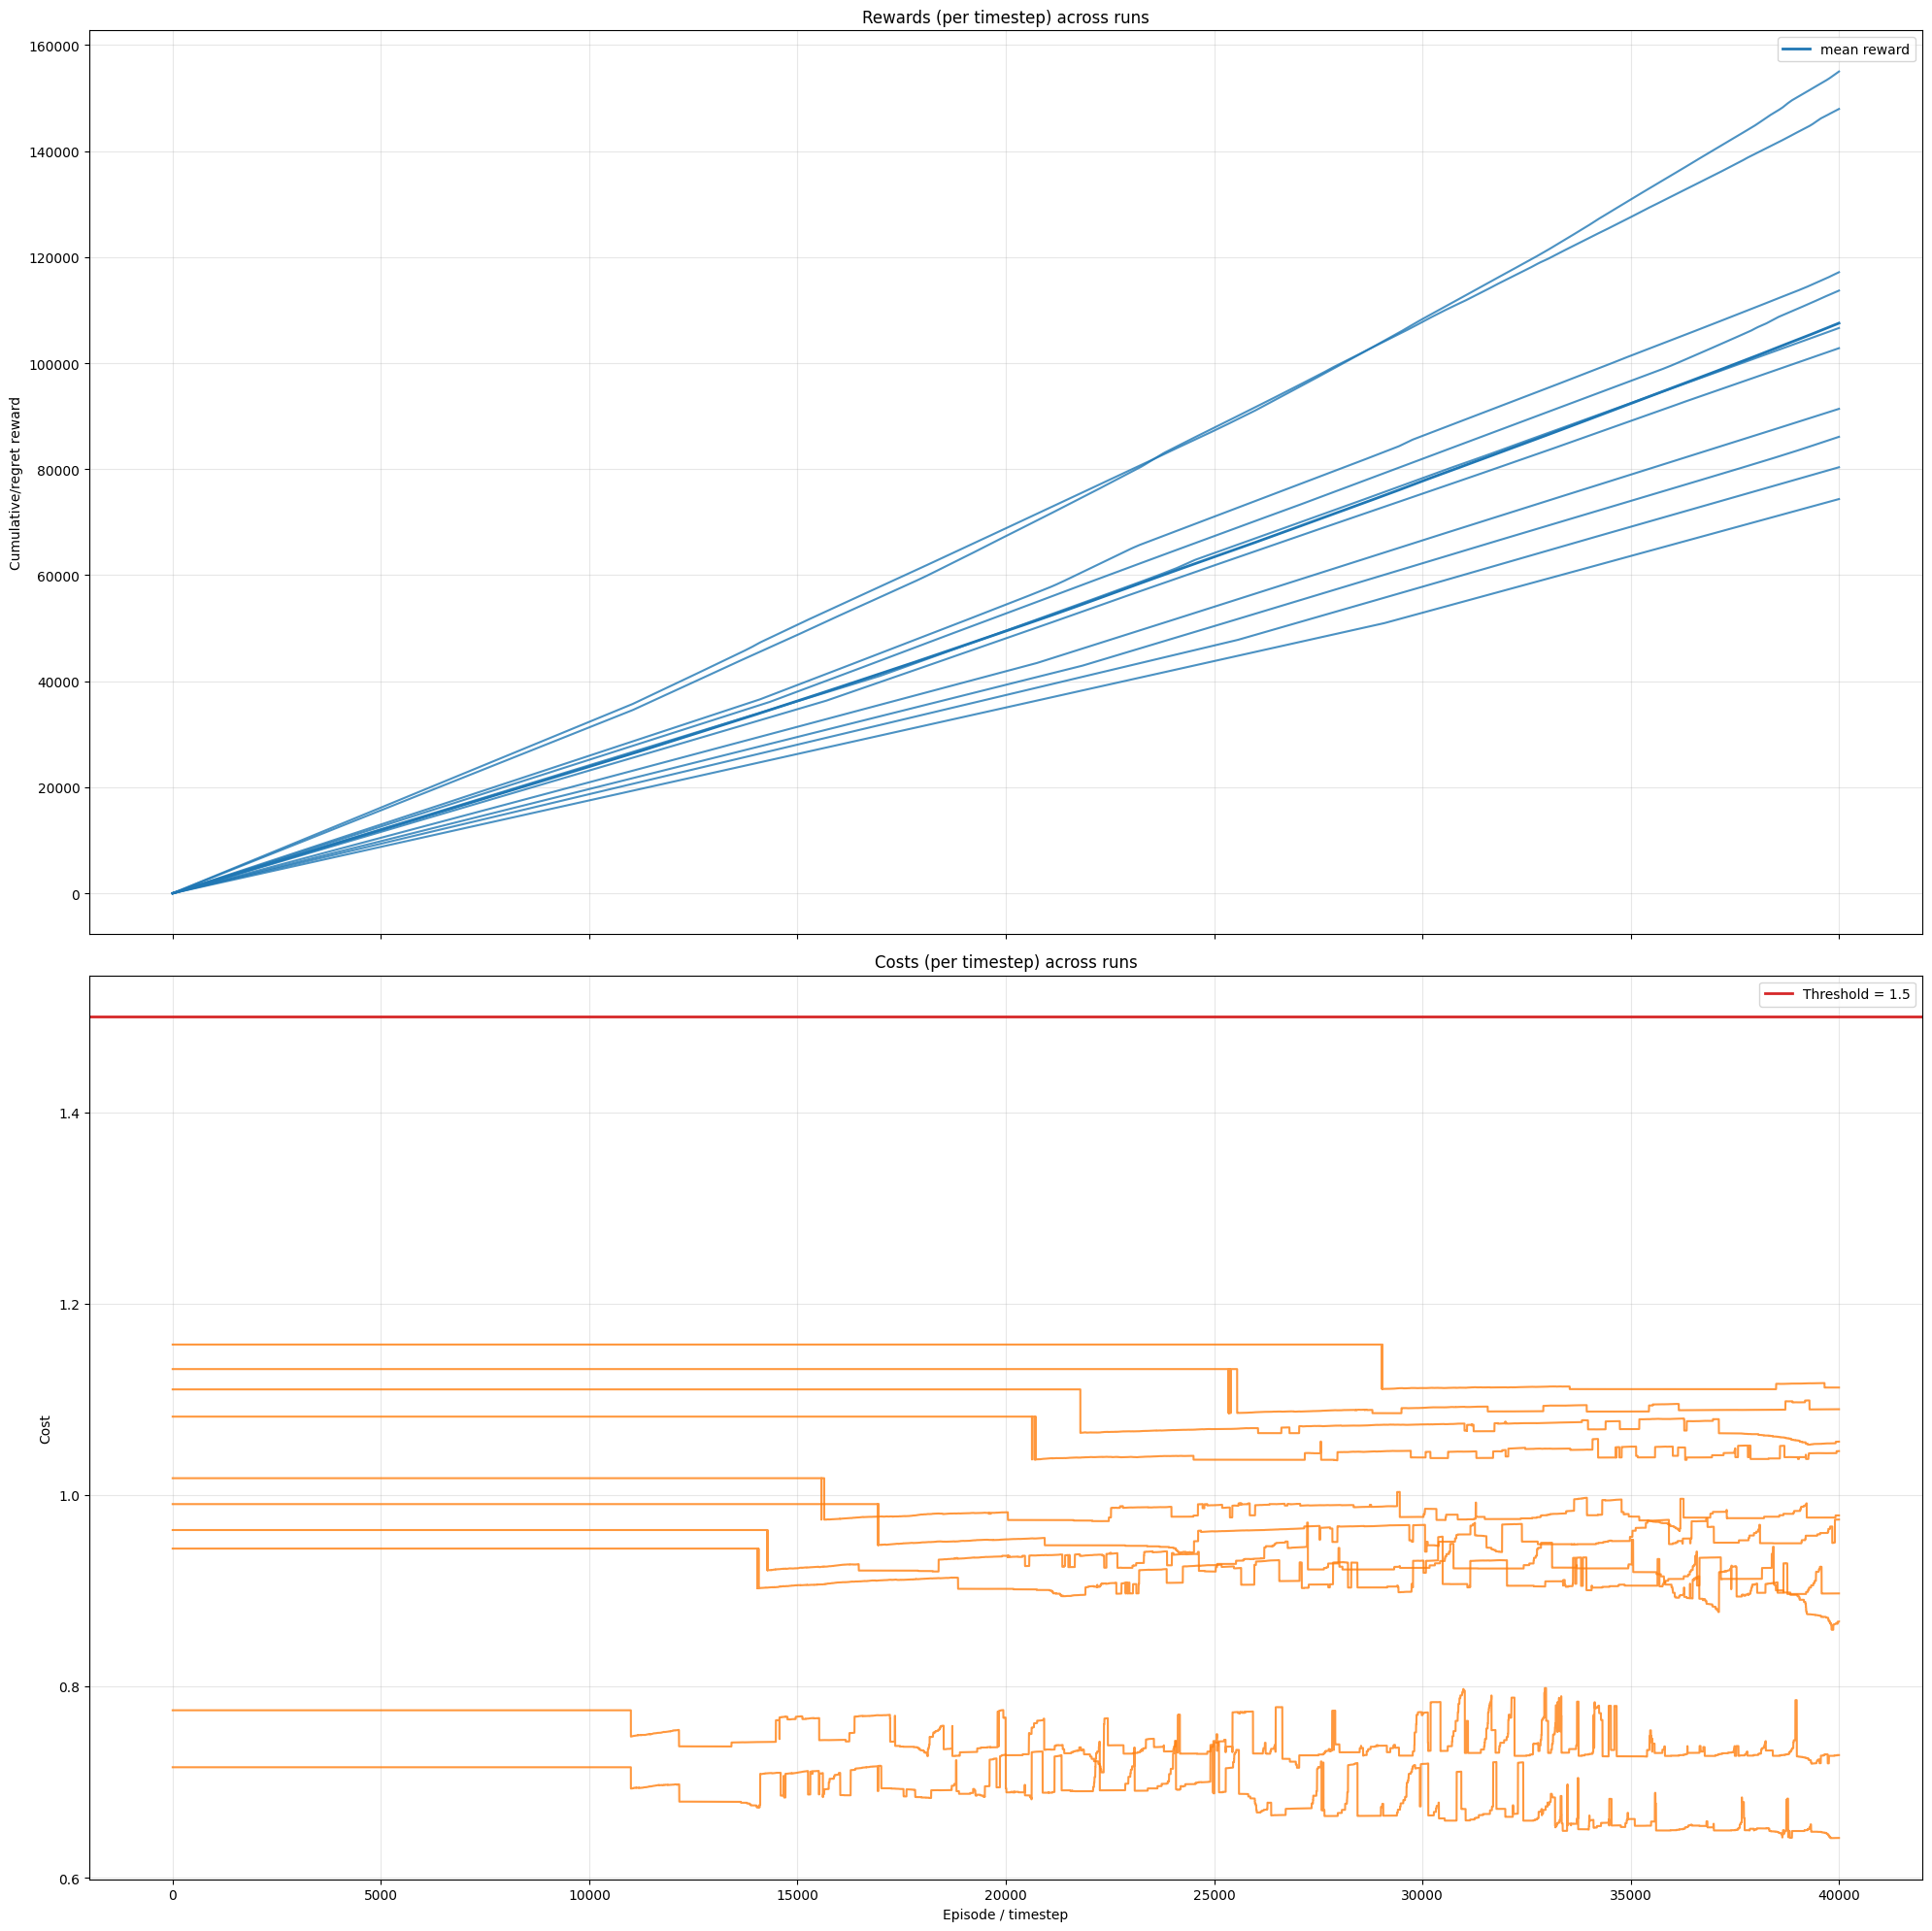

In [3]:
noise_arr = [0.33994760, 0.25363799, 0.31864008, 0.30796535, 0.33609112, 0.33084822, 0.31335413, 0.30405411, 0.34453611, 0.26760585]
# Constrauct safe policy with high entropy such that it encourages exploration for policy gradient approach
env = make_env(0.4)  
pi_s, u_s, v_s = LP(env)
tot_e = 40000
r_dope = np.zeros((len(noise_arr), tot_e))   # use tuple shape
c_dope = np.zeros((len(noise_arr), tot_e)) 

for i, noise in enumerate(noise_arr):
    env = make_env(noise)
    r_dope[i, :], c_dope[i, :] = DOPE(env, pi_s, tot_e)
with open("data/r_c_history_dope.pkl", "wb") as f:  # Save as a pickle file
    pickle.dump({"r_dope": r_dope, "c_dope": c_dope}, f)
print("Saved r_dope and c_dope to data/r_c_history_dope.pkl")

# Plot reward and cost histories (handles multiple runs)
n_runs, T = r_dope.shape

fig, axes = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

x = np.arange(T)

# Rewards
for i in range(n_runs):
	axes[0].plot(x, r_dope[i], color='C0', alpha=0.8)
axes[0].plot(x, np.mean(r_dope, axis=0), color='C0', lw=2, label='mean reward')
axes[0].set_ylabel('Cumulative/regret reward')
axes[0].set_title('Rewards (per timestep) across runs')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Costs
for i in range(n_runs):
	axes[1].plot(x, c_dope[i], color='C1', alpha=0.8)
axes[1].set_ylabel('Cost')
axes[1].set_xlabel('Episode / timestep')
axes[1].set_title('Costs (per timestep) across runs')
axes[1].axhline(y =  1.5, color = 'tab:red',label = 'Threshold = 1.5', linewidth=2)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("plots/reg_and_cost_dope.png", format='png', dpi=800)  # Save with 800 dpi
plt.show()